In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as npm
import pandas as pd
import scipy.sparse as sps
from datetime import datetime
from sklearn.model_selection import train_test_split

### Preprocessing

Read the data.

In [2]:
col_names = ['user_id', 'rating', 'date']
df = pd.read_csv('combined_data_1.txt', sep=',', header=None, names=col_names)

In [3]:
df.head(10)

,user_id,rating,date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
5,823519,3.0,2004-05-03
6,893988,3.0,2005-11-17
7,124105,4.0,2004-08-05
8,1248029,3.0,2004-04-22
9,1842128,4.0,2004-05-09


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 3 columns):
user_id    object
rating     float64
date       object
dtypes: float64(1), object(2)
memory usage: 550.7+ MB


Create an array with movies' ids and add it as a new column into the dataframe.

In [5]:
len_df = len(df)
len_df

24058263

In [6]:
df_mrows = pd.DataFrame(pd.isnull(df['rating']))
df_mrows = df_mrows[df_mrows['rating'] == True]
df_mrows.reset_index(inplace=True, drop=False)
df_mrows.drop(columns=['rating'], inplace=True)

In [7]:
df_mrows = df_mrows.append({'index': len_df}, ignore_index=True)

In [8]:
cur_mid = 1
df_mcol = np.array([], dtype=int)

In [9]:
for start_idx, end_idx in zip(df_mrows['index'], df_mrows['index'][1:]):
    temp = np.full((1, end_idx - start_idx - 1), cur_mid)
    df_mcol = np.append(df_mcol, temp)
    cur_mid += 1

In [10]:
assert len_df == len(df_mcol) + len(df_mrows) - 1

In [11]:
df = df[pd.notnull(df['rating'])]
df['movie_id'] = df_mcol

In [12]:
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
df.head(10)

,user_id,rating,date,movie_id
0,2282641,3.0,2005-02-16,2960
1,350806,3.0,2005-07-06,2209
2,363775,2.0,2003-04-10,1585
3,813189,3.0,2005-09-03,985
4,92177,3.0,2004-11-12,231
5,1429362,1.0,2005-08-16,989
6,744121,4.0,2005-05-15,2171
7,2488496,4.0,2004-09-18,1754
8,2129953,5.0,2002-02-15,788
9,2554977,3.0,2004-01-19,2409


Create the user & movie one-hot encoding matrix and get it in the CSR format.

In [14]:
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()
n_ratings = df.shape[0]

In [15]:
uid_to_idx, idx_to_uid = {}, {}
for idx, user_id in enumerate(df['user_id'].unique()):
    uid_to_idx[user_id] = idx
    idx_to_uid[idx] = user_id

In [16]:
mid_to_idx, idx_to_mid = {}, {}
for idx, movie_id in enumerate(df['movie_id'].unique()):
    mid_to_idx[movie_id] = idx + n_users
    idx_to_mid[idx + n_users] = movie_id

In [17]:
def map_ids(row, mapper):
    return mapper[row]

In [18]:
user_cols = df['user_id'].apply(map_ids, args=[uid_to_idx]).values
movie_cols = df['movie_id'].apply(map_ids, args=[mid_to_idx]).values

In [19]:
indices = [x for z in zip(user_cols, movie_cols) for x in z]
indptr = np.arange((n_ratings + 1) * 2, step=2)
data = np.ones(n_ratings * 2, dtype=int)

In [20]:
csr_mtx = sps.csr_matrix((data, indices, indptr), shape=(n_ratings, n_users + n_movies))

In [21]:
assert csr_mtx.getrow(0).toarray()[0][n_users] == 1

### FM-algorithm implementation

In [22]:
def batch_generator(X, y, size):
    idx_array = np.arange(size)
    np.random.shuffle(idx_array)
    return X[idx_array, :], y[idx_array]

In [23]:
def rmse(y, y_pred):
    return np.sqrt(np.sum((y - y_pred) ** 2) / len(y))

In [24]:
def prediction(X, w_0, w, factors):
    interaction_mtx = ((np.power(X * factors, 2) - X.power(2) * np.power(factors, 2)) / 2).sum(axis=1)
    wX = X.multiply(w).sum(axis=1)
    return w_0 + np.squeeze(np.asarray(wX)) + interaction_mtx

In [25]:
def gradient(X, w_0, w, factors, loss, reg_lambda=0.1):
    grad_w0 = -(np.sum(loss) - reg_lambda * w_0)
    grad_w = -(X.T * loss - reg_lambda * w)

    temp = X.power(2).T.multiply(loss).T.tocsr()
    csr_mtx = np.sum([temp[i, :].T.multiply(factors) for i in range(X.shape[0])], axis=0)
    grad_v = np.asarray(csr_mtx - X.T.multiply(loss).dot(X * factors)) + reg_lambda * factors

    return grad_w0, grad_w, grad_v

In [26]:
def update(X, w_0, w, factors, loss, learn_rate=0.001):
    grad_w0, grad_w, grad_v = gradient(X, w_0, w, factors, loss)
    return w_0 - learn_rate * grad_w0, w - learn_rate * grad_w, factors - learn_rate * grad_v

In [27]:
X_train, X_test, y_train, y_test = train_test_split(csr_mtx, df['rating'].values.astype(int), test_size=0.2)

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [50]:
batch_size = 1024
n_factors = 16

In [58]:
w_0 = 0.0
w = np.zeros(X_train.shape[1])
factors = np.asarray(npm.randn((X_train.shape[1], n_factors)))

In [59]:
valid_costs = []

Mini-batch gradient descent (sort of).

At each iteration it takes a random batch of the train set and updates parameters, until the desired error value is reached on the validation set.

In [60]:
start_time = datetime.now()

In [136]:
while True:
    batch_X, batch_y = batch_generator(X_train, y_train, batch_size)
    
    loss = batch_y - prediction(batch_X, w_0, w, factors)
    w_0, w, factors = update(batch_X, w_0, w, factors, loss)

    valid_costs.append(rmse(y_valid, prediction(X_valid, w_0, w, factors)))
    if valid_costs[-1] < 1.1:
        break

In [137]:
end_time = datetime.now()

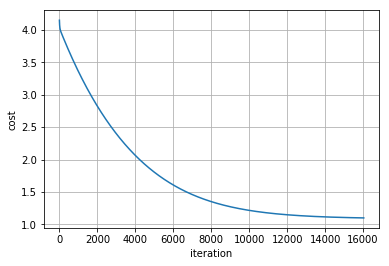

In [138]:
n_iters = len(valid_costs)

plt.plot(range(n_iters), valid_costs)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.grid()

In [140]:
error = rmse(y_test, prediction(X_test, w_0, w, factors))
error

1.1002194830379304

In [141]:
timedelta = end_time - start_time

print(f"Training took {timedelta.seconds // 3600} hours and {n_iters} iterations")

Training took 23 hours and 16040 iterations


Save the final parameters' values.

In [142]:
factor_names = [f'v_{i}' for i in range(factors.shape[1])]
values = {'w_0': w_0, 'w': w, **dict(zip(factor_names, factors.T))}

In [143]:
col_names = ['w_0', 'w', *factor_names]
output = pd.DataFrame(data=values, columns=col_names)

In [144]:
output.to_csv('params.csv', index=False, header=True)